In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pathfile = '/Users/sarahhu/ibl_photometry/DR-5HT/'
metadf = pd.read_parquet(pathfile + 'sessions.pqt')
metadf.reset_index(inplace=True)
metadf.head()

,index,eid,subject,start_time,task_protocol,session_type,session_n,NM,target,roi
0,34,fe2a712b-014b-47e7-b2ac-f85d0571cf44,ZFM-03065,2021-08-27T10:18:12.784055,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,4,5HT,[DR],[Region1G]
1,35,ba01bf35-8a0d-4ca3-a66e-b3a540b21128,ZFM-03059,2021-08-27T11:18:32.529960,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,4,5HT,[DR],[Region1G]
2,38,f2a6559d-1e45-4e83-8f65-1295ef50ed4b,ZFM-03065,2021-08-30T08:29:50.008373,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,5,5HT,[DR],[Region1G]
3,42,c5cdd496-7400-4c0f-b326-55016bce4fcf,ZFM-03065,2021-08-31T10:23:23.726423,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,6,5HT,[DR],[Region1G]
4,49,fd22820d-a2c2-4c06-b90e-f399344e1c0a,ZFM-03059,2021-09-01T09:54:32.034120,_iblrig_NPH_tasks_trainingChoiceWorld6.4.2,training,7,5HT,[DR],[Region1G]


In [16]:
import sys
# Change this to your path to ibl-photometry
sys.path.append('/Users/sarahhu/ibl-photometry/src')

In [19]:
from dataclasses import dataclass

@dataclass
class Params: 
    """
    Parameters for PSTH and photometry analysis.

    Attributes
    ----------
    pre_time : float
        Time before event to include in the analysis window (in seconds).
    post_time : float
        Time after event to include in the analysis window (in seconds).
    bin_size : float
        Size of time bins for the histogram (in seconds).
    baseline_time : float
        Time window before the event used for baseline fluorescence calculation (in seconds).
    """
    pre_time: float=4
    post_time: float=6
    bin_size: float=0.1
    baseline_time: float=0.5

class Photometry: 
    """
    Class for analyzing photometry data aligned to behavioral events.

    Parameters
    ----------
    eid : str
        Experiment ID used to load data files.

    trial_idx : list, optional
        Indices of trial numbers to select from the session. 

    """

    def __init__(self, eid, trial_idx=None):
        
        # private instances
        self.__pathfile = '/Users/sarahhu/ibl_photometry/DR-5HT/'
        self.__eid = eid
        
        if trial_idx is not None:
            self.__trials_df = self.load_trials()[self.__convert_trial_idx(trial_idx)]
        else: 
            self.__trials_df = self.load_trials()
            
        self.__gcamp_df = self.load_photometry()

        # public instances
        self.firstMovement_times = self.__trials_df['firstMovement_times']
        self.contrastRight = self.__trials_df['contrastRight']
        self.choice = self.__trials_df['choice']
        self.contrastLeft = self.__trials_df['contrastLeft']
        self.response_times = self.__trials_df['response_times']
        self.feedbackType = self.__trials_df['feedbackType']
        self.probabilityLeft = self.__trials_df['probabilityLeft']
        self.stimOn_times = self.__trials_df['stimOn_times']
        self.goCue_times = self.__trials_df['goCue_times']
        self.feedback_times = self.__trials_df['feedback_times']

    
    def __convert_trial_idx(self, trial_idx): 
        total_trial = self.load_trials().shape[0]
        if len(trial_idx) == 2:
            tid = [True if i in range(trial_idx[0], trial_idx[1]) else False for i in range(total_trial)]
        else:
            tid = trial_idx
        return tid

    # functions for loading
    def load_photometry(self):
        df = pd.read_parquet(self.__pathfile + self.__eid + '_gcamp.pqt')
        return df

    def load_trials(self): 
        df = pd.read_parquet(self.__pathfile + self.__eid + '_trials.pqt')
        return df

    def load_isosbestic(self): 
        df = pd.read_parquet(self.__pathfile + self.__eid + '_isosbestic.pqt')
        return df

    # Modified based on bin_spikes from brainbox.singlecell 
    def __bin_photometry(self, align_times, params: Params):
        """
        Internal method to compute trial-aligned, binned photometry signal (ΔF/F).
        Each trial is aligned to the specified event, and its fluorescence trace is:
        1. Binned over time relative to the event.
        2. Normalized by its own baseline fluorescence to compute ΔF/F.
        3. Returned as a matrix of shape (n_trials, n_bins).
        """

        # align_times = np.array(self.__trials_df[align_times])
       
        signal = self.__gcamp_df.values[:,0]
        times = list(self.__gcamp_df.index) 
        
        n_bins_pre = int(np.ceil(params.pre_time / params.bin_size))
        n_bins_post = int(np.ceil(params.post_time / params.bin_size))
        n_bins = n_bins_pre + n_bins_post
        tscale = np.arange(-n_bins_pre, n_bins_post + 1) * params.bin_size
        ts = np.repeat(align_times[:, np.newaxis], tscale.size, axis=1) + tscale
        epoch_idxs = np.searchsorted(times, np.c_[ts[:, 0], ts[:, -1]])
        bins = np.zeros(shape=(align_times.shape[0], n_bins))

        for i, (ep, t) in enumerate(zip(epoch_idxs, ts)):

            # Determine baseline period indices
            baseline_start = align_times[i] - params.baseline_time
            baseline_end = align_times[i]  # up to event onset
            baseline_idx = np.searchsorted(times, [baseline_start, baseline_end])

            # Compute baseline fluorescence (mean during baseline window)
            if baseline_idx[0] < baseline_idx[1]:  # ensure valid window
                F_baseline = np.mean(signal[baseline_idx[0]:baseline_idx[1]])
            else:
                F_baseline = np.nan  # if no points in baseline window
            
            # also account for underlying (longer-term) fluctuations one second prior to events
            fluctuation_time = align_times[i] - 3  # 1s window hard-coded!
            fluctuation_idx = np.searchsorted(times, [fluctuation_time, align_times[i]])
            fluctuation_signal = signal[fluctuation_idx[0]:fluctuation_idx[1]]
            if len(fluctuation_signal) > 0:
                fluc_std = np.nanstd(fluctuation_signal, axis=0)
            else:
                fluc_std = np.nan

            # Compute fluorescence during trial window
            trial_signal = signal[ep[0]:ep[1]]
            xind = (np.floor((times[ep[0]:ep[1]] - t[0]) / params.bin_size)).astype(np.int64)
            
            r_counts = np.bincount(xind, minlength=tscale.shape[0])
            r_sum = np.bincount(xind, minlength=tscale.shape[0], weights=trial_signal)

            # avoid division by zero
            with np.errstate(divide='ignore', invalid='ignore'):
                r_mean = np.true_divide(r_sum, r_counts)
                r_mean[r_counts == 0] = np.nan  # if no data points in bin, set to NaN

            binned_signal = r_mean[:-1]  # remove the last bin 

            # Compute dF/F for this trial
            
            # fluc_std = 1 # placeholder

            if not np.isnan(F_baseline) and F_baseline != 0 and not np.isnan(fluc_std) and fluc_std != 0:
                bins[i, :] = (binned_signal - F_baseline) / F_baseline / fluc_std 
            else:
                bins[i, :] = np.nan  # skip if baseline invalid or zero

        tscale = (tscale[:-1] + tscale[1:]) / 2

        return bins, tscale
    
    def __get_filtered_trials_df(self, side=None, feedback_type=None, bias=None):
        
        # Start with full mask (all True)
        mask = np.ones(len(self.__trials_df), dtype=bool)

        # Apply side filter
        if side == 'left':
            mask &= ~np.isnan(self.__trials_df['contrastLeft'])
        elif side == 'right':
            mask &= ~np.isnan(self.__trials_df['contrastRight'])

        # Apply feedback_type filter
        if feedback_type == 1.0:
            mask &= self.__trials_df['feedbackType'] == 1.0
        elif feedback_type == -1.0:
            mask &= self.__trials_df['feedbackType'] == -1.0
        elif feedback_type is not None:
            raise Exception("feedback_type must be -1.0 (incorrect) or 1.0 (correct)")

        # Apply bias filter
        if bias == 0:
            mask &= self.__trials_df['probabilityLeft'] == 0.5
        elif bias == 1:
            mask &= (self.__trials_df['probabilityLeft'] == 0.2) | (self.__trials_df['probabilityLeft'] == 0.8)
        elif bias is not None:
            raise Exception("bias must be 0 (no bias) or 1 (biased)")
        
        return mask

In [20]:
# focus on one mouse: ZFM-03059
# extract all/some of its training session eids
mouse_df = metadf[metadf['subject']=='ZFM-03059']
train_idx = np.asarray(mouse_df['session_type']=='training').nonzero()
mouse_train_df = mouse_df.iloc[train_idx]
sessions = mouse_train_df['eid'][10:15]
sessions

params = Params(pre_time=2, post_time=2, bin_size=0.1, baseline_time=0.5)
session1 = Photometry(sessions.values[4])

In [21]:
session = Photometry(metadf.iloc[0]['eid'])

In [22]:
gcamp = session.load_photometry()
iso = session.load_isosbestic()

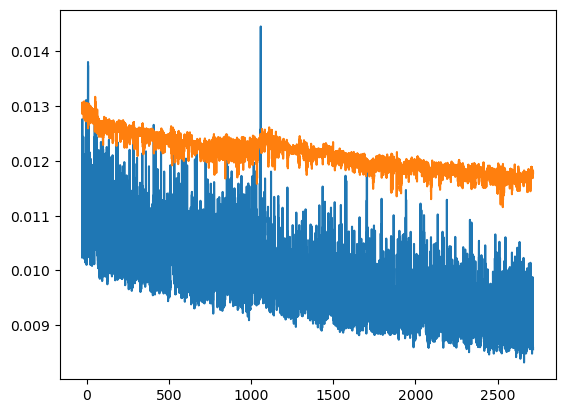

In [23]:
plt.plot(gcamp)
plt.plot(iso)

In [24]:
from iblphotometry.metrics import n_early_samples, n_unique_samples, ar_score
## TODO: fix_repeated_sampling only works for raw interleaved photometry data
from scipy.signal import medfilt

def sliding_deviance(
    A: pd.Series | np.ndarray,
    w_len: int = 151,
) -> float:
    a = A.values if isinstance(A, pd.Series) else A
    running_median = medfilt(a, kernel_size=w_len)
    return np.median(np.abs(a - running_median) / running_median)

In [25]:
# Check that all samples are appropriately timed
# Early samples are an indication that there are artifacts/ gcamp-iso identity swaps

print(n_early_samples(gcamp))
print(n_early_samples(iso))

0
0


In [26]:
# Check that the recording has a high (>100, >1000) number of unique samples
# A low number indicates that the channel label is wrong, or the signal is too low amplitude
print(n_unique_samples(gcamp))

15805


In [27]:
# Check that the recording has a high amplitude ("median absolute deviance")
deviance_threshold = 0.0005 # Set an approproaite threshold, this is likely very liberal
deviance = sliding_deviance(gcamp[gcamp.columns[0]])
print(deviance, deviance > deviance_threshold)

0.022407527481648037 True


In [28]:
# Check that the recording has temporal dependencies
# A simple "autoregressive" model tries to predict the signal based on preceding samples
arscore_threshold = 0.25 # Set an approproaite threshold, this is likely very liberal
r_squared = ar_score(gcamp[gcamp.columns[0]])
print(r_squared, r_squared > arscore_threshold)

0.9506278601087761 True
